In [1]:
suppressPackageStartupMessages({
    library(sna)
    library(testthat)
    library(network)
    library(ergm)
})

# Assessment Network Structure
In this assessment you will use the appraoches in the tutorial in week 10 but apply it to a directed network. The first part of this notebook provides some helpful routines for directed networks and outlines some important ways in which routines have to be modified.

First we begin with a warmup question.

### Question 1 (3 points)

When simulating random networks, you are allocating some propobabitily to each possible network. For an undirected network on $n$ nodes there a total of $2^{n(n-1)/2}$ possible networks. For a directed network on $n$ nodes, how many possible networks are there? Calculate the number of possible directed networks on $n$ nodes in terms of $n$:

In [2]:
enumerate.nets <- function(n)
{
### BEGIN SOLUTION
total <- 2^(n*(n-1))
### END SOLUTION
return(total)
}    

In [3]:
# this cell contains tests (including some hidden tests) that your answer to Question 1 should pass
### BEGIN HIDDEN TESTS
expect_equal(enumerate.nets(5),  2^(5*(5-1)) ) 
expect_equal(enumerate.nets(7),  2^(7*(7-1)) ) 
expect_equal(enumerate.nets(9),  2^(9*(9-1)) ) 
### END HIDDEN TESTS

# Directed networks
In this assignment you will follow the approach in Tutorial 2 (Week 10) but apply it to directed networks. The relevant metrics for directed networks are those in Tutorial 1 (Week 9). In terms of simulation models, for directed networks there are some minor differenced in what the arguments you use. Below, the syntax is provided based on Kapferer's tailors. Throughout we are going to draw 1000 networks whenvever we use a null distribution


### Kapferer's tailors
Load Kapferer's (1972) Zambian $n=39$ tailors network.

In [4]:
temp <- tempfile()
download.file("https://raw.githubusercontent.com/johankoskinen/BayesERGM/main/data/kapferer.txt",temp)
kapf  <-  read.table(temp)# four adjacency matrices stacked on top of each other
unlink(temp)
# "instrumental" (work- and assistance-related) interactions
X <- as.matrix( kapf[(2*39+1):(3*39),])# KAPFTI1 non-symmetric, binary: time 1
n <- dim(X)[1]

# Directed Bernoulli model
Draw 1000 networks. We will say that for these networks $X \thicksim Bern(p)$

In [5]:
m <- 1000
Xsim <- rgraph( n, # match network size
                 m= m, # generate 1000 random networks
                 tprob = gden(X), # match tie-probability to density
                 mode='digraph') # this is the main difference from tutorial 2

# Conditionally uniform density

The conditionally uniform distribution, conditional on the density, now needs the number of *arcs*, which is the total degree
$$
\sum_{i=1}^n\sum_{j=1}^n X_{ij}
$$
Consequently you do not divide the sum of the matrix by 2 (in fact, since dyads need not be symmetric, you may have an odd number of arcs). We use the notation that $X \thicksim U | L $. Now do draw 1000 networks

In [6]:
Xunif <- rgnm( n =m,# generate 1000 random networks # match network size
                 nv = n, # the size of the networks
                 m = sum(X), # match the number of ties
                 mode='digraph') # make sure these are undirected graphs

# Conditionally uniform conditional on degree distribution

Since directed networks have both an *indegree* as well as an *outdegree* distribution, the conditionally uniform distribution conditional on the degree distribution can condition on either or both. For an adjacency matrix $X$, we let $X_{\cdot,+} = \left( \sum_j X_{ij}\right)$ be the vector of out-degrees, and
$$
X_{+,\cdot} = \left( \sum_i X_{ij} \right)^{T}
$$
be the vector of indegrees.

We can define three distributions. We let $X \thicksim U \mid X_{\cdot+}=d$ mean that the distribution is uniform on all the graphs that have *the exact same outdegree distribution*. Thus
$$ 
\Pr( X = x) = \left\{
\begin{array}{lr}
	c^{-1},&\text{if } x_{\cdot,+}=d\\
	0,&\text{else}
\end{array} 
\right. {\text{,}}
$$
where $c$ is the number of graphs with outdegree distribution $d$. When it is unambiguous, we will write  $X \thicksim U \mid d_{out}$.

We let $X \thicksim U \mid X_{+,\cdot}=d$ mean that the distribution is uniform on all the graphs that have *the exact same indegree distribution*. Thus
$$ 
\Pr( X = x) = \left\{
\begin{array}{lr}
	c^{-1},&\text{if } x_{+,\cdot}=d\\
	0,&\text{else}
\end{array} 
\right. {\text{,}}
$$
where $c$ is the number of graphs with indegree distribution $d$. When it is unambiguous, we will write  $X \thicksim U \mid d_{in}$.

We let $X \thicksim U \mid X_{\cdot,+}=d_{out},X_{+,\cdot}=d_{in}$ mean that the distribution is uniform on all the graphs that have *the exact same outdegree and indegree distribution*. Thus
$$ 
\Pr( X = x) = \left\{
\begin{array}{lr}
	c^{-1},&\text{if } x_{\cdot,+}=d_{out} \text{ and } x_{+,\cdot}=d_{in}\\
	0,&\text{else}
\end{array} 
\right. {\text{,}}
$$
where $c$ is the number of graphs with outdegree distribution $d_{out}$ and indegree distribution $d_{in}$. When it is unambiguous, we will write  $X \thicksim U \mid d_{out},d_{in}$.

The simulation method is the same as in Tutorial 2 (week 10) but with the specific degree distribution. Firstly, recall that the simulation function requires the starting network to be a network object:


In [7]:
X.net <- as.network(X,directed=TRUE)
X.net

 Network attributes:
  vertices = 39 
  directed = TRUE 
  hyper = FALSE 
  loops = FALSE 
  multiple = FALSE 
  bipartite = FALSE 
  total edges= 109 
    missing edges= 0 
    non-missing edges= 109 

 Vertex attribute names: 
    vertex.names 

No edge attributes

To simulate, again, use a function from the `ergm` package.

For $X \thicksim U \mid d_{out}$

In [8]:
Xoutdegs <- simulate(X.net~edges,
                    coef=c(0),# the role of coefficients will become clear further on
                    constraints=~odegrees,# this guarantees that only networks with the same *outdegree* are generated
                    nsim=m,# set the number of draws
                    control=control.simulate(MCMC.burnin=100000))# you need to bump up the default burnin, otherwise 
                                        # the networks are too similar to the starting point, the observed network

For $X \thicksim U \mid d_{in}$

In [9]:
Xindegs <- simulate(X.net~edges,
                    coef=c(0),# the role of coefficients will become clear further on
                    constraints=~idegrees,# this guarantees that only networks with the same *indegree* are generated
                    nsim=m,# set the number of draws
                    control=control.simulate(MCMC.burnin=100000))# you need to bump up the default burnin, otherwise 
                                            #the networks are too similar to the starting point, the observed network

Finally, for $X \thicksim U \mid X_{\cdot,+}=d_{out},X_{+,\cdot}=d_{in}$

In [10]:
Xudegs <- simulate(X.net~edges,
                    coef=c(0),# the role of coefficients will become clear further on
                    constraints=~degrees,# this guarantees that only networks with the same in/ and outdegree are generated
                    nsim=m,# set the number of draws
                    control=control.simulate(MCMC.burnin=100000))# you need to bump up the default burnin, otherwise the 
                                            # networks are too similar to the starting point, the observed network

# Conditional U | MAN
For directed networks there is also an additional random graph model, the conditional $U \mid MAN$ random graph model. The  $U \mid MAN$ generates random graphs with a prescribed dyad census. For example, for the Kapferer's tailors data, we simulate

In [11]:
obs.dyad.census <- dyad.census(X)
Xuman <- rguman( n =m,# generate 1000 random networks # match network size
                 nv = n, # the size of the networks
               mut = obs.dyad.census[1],# the number of mutual dyads
               asym = obs.dyad.census[2],# the number of asymetric dyads
               null = obs.dyad.census[3],# the number of null dyads
               method='exact') # make sure these are undirected graphs

> Note: remember to use the correct dyad census. The triad census must add up to $n(n-1)/2$.

# Calculating metrics for simulated networks

We can calculate metrics for simulated directed networks the way we calculated metrics for undirected networks in Tutorial 2. Here we outline some additional things to think about.

### Dyad census

When you calculate an the dyad census for an $m\times n \times n$ array, sna returns it as an $m \times 3$ matrix, for example for Kapferer's tailors:

In [12]:
head(dyad.census(Xuman))# see! all graphs have the same dyad census

Mut,Asym,Null
33,43,665
33,43,665
33,43,665
33,43,665
33,43,665
33,43,665


Even if you have a list of networks, `sna` returns the dyad census as the same matrix. To do a histogram of, say, the number of mutual dyads, just pick the first column

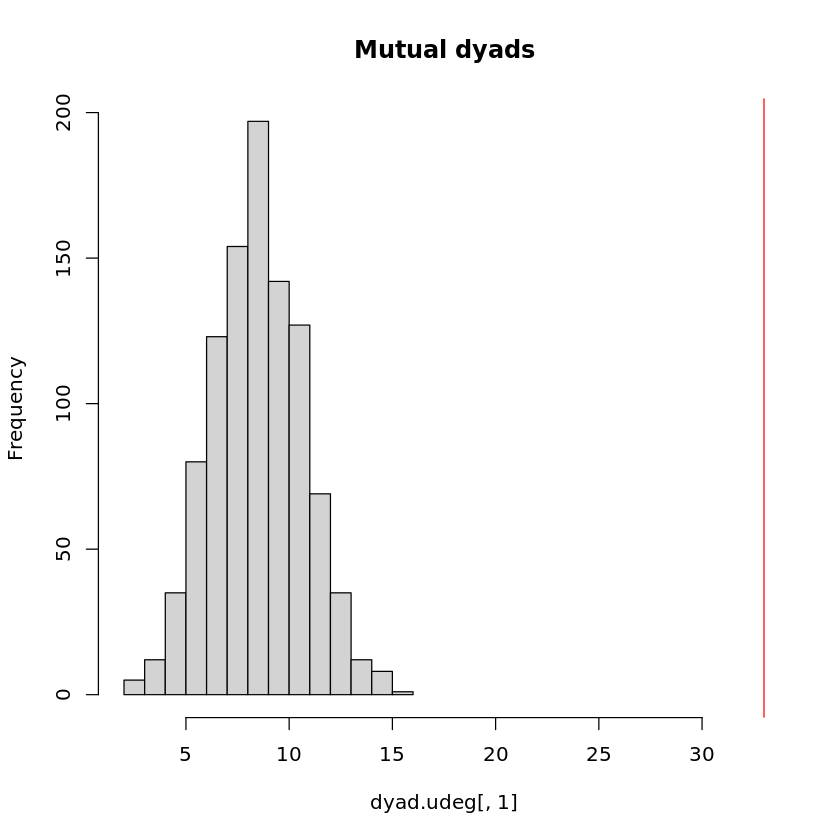

In [13]:
dyad.udeg <- dyad.census(Xudegs)
hist( dyad.udeg[,1] ,
      xlim = range(dyad.udeg[,1],obs.dyad.census[1]),
      main = 'Mutual dyads')
abline( v = obs.dyad.census[1], col ='red')

### Triad census

Similar to the dyad census across a number of simulate graphs, triad census for directed networks returns an $m\times 16$ array 


In [14]:
head( triad.census(Xudegs ))

003,012,102,021D,021U,021C,111D,111U,030T,030C,201,120D,120U,120C,210,300
6035,2369,139,137,88,211,26,59,37,11,1,1,8,10,7,0
6109,2225,202,152,74,209,44,52,34,11,5,4,7,8,3,0
6082,2270,174,153,88,216,32,53,29,10,4,4,7,16,1,0
6017,2390,110,147,93,234,23,56,37,8,2,2,4,10,5,1
6130,2193,222,142,70,206,45,66,31,6,5,8,4,8,2,1
6090,2253,172,159,86,217,39,56,31,11,3,4,3,14,1,0


### Degree distributions
For simulated networks we can now compare both indegree and outdegree distributions. You can plot them using the functions of Tutorial 2 but be careful to pick the right `cmode`


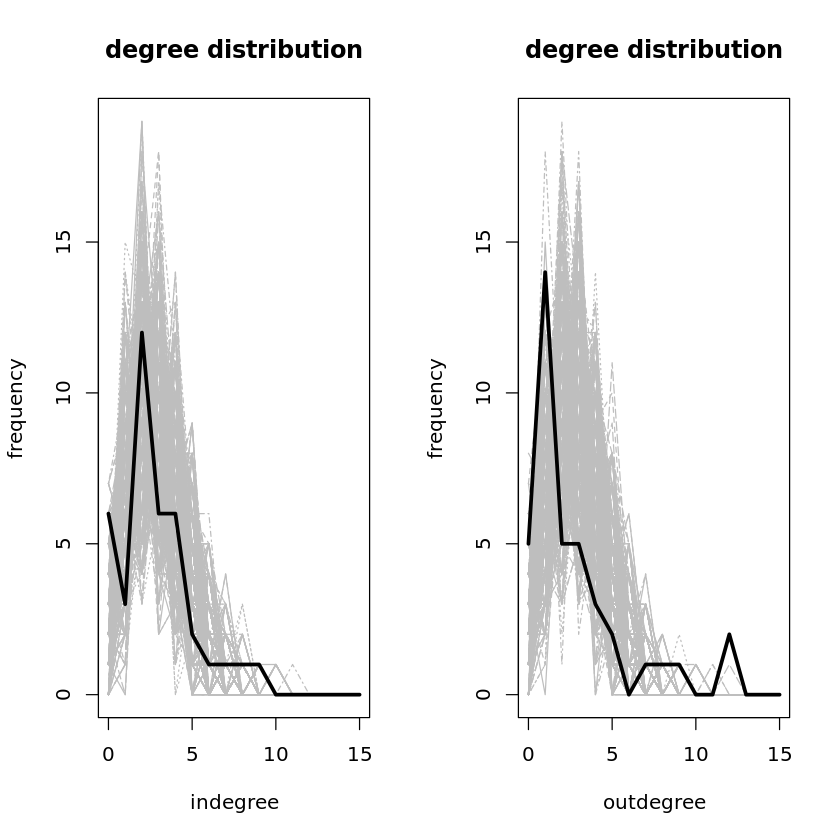

In [15]:
max.deg <- 15
par(mfrow=c(1,2))
degrees <-degree(Xsim,g=c(1:m), cmode='indegree')# you can calculate the degree distributions for all graphs
obs.deg <- degree( X , cmode='indegree')

deg.sist <- cbind( matrix( colSums(degrees==0),m,1),
                  t(apply(degrees,2,function(x) tabulate(x, nbins=max.deg) ) ) )# when tabulating we need to add isolates 

obs.deg <- c( sum(obs.deg==0) ,tabulate(obs.deg, nbins=max.deg)  )
  
matplot(c(0:(max.deg)), t(deg.sist) ,
        type ='l',col='grey',
        main='degree distribution' ,xlab ='indegree',ylab='frequency',
        ylim = range( deg.sist,obs.deg))
lines(c(0:(max.deg)),obs.deg,pch=24,
      col='black',lwd=3 )
#### === outdegre
degrees <-degree(Xsim,g=c(1:m), cmode='outdegree')# you can calculate the degree distributions for all graphs
obs.deg <- degree( X , cmode='outdegree')

deg.sist <- cbind( matrix( colSums(degrees==0),m,1),
                  t(apply(degrees,2,function(x) tabulate(x, nbins=max.deg) ) ) )# when tabulating we need to add isolates 

obs.deg <- c( sum(obs.deg==0) ,tabulate(obs.deg, nbins=max.deg)  )
  
matplot(c(0:(max.deg)), t(deg.sist) ,
        type ='l',col= 'grey',
        main='degree distribution' ,xlab ='outdegree',ylab='frequency',
        ylim = range( deg.sist,obs.deg))
lines(c(0:(max.deg)),obs.deg,pch=24,lty=1,
      col='black',lwd=3 )

For a single network you can plot the indegree distribution against the outdegree distribution

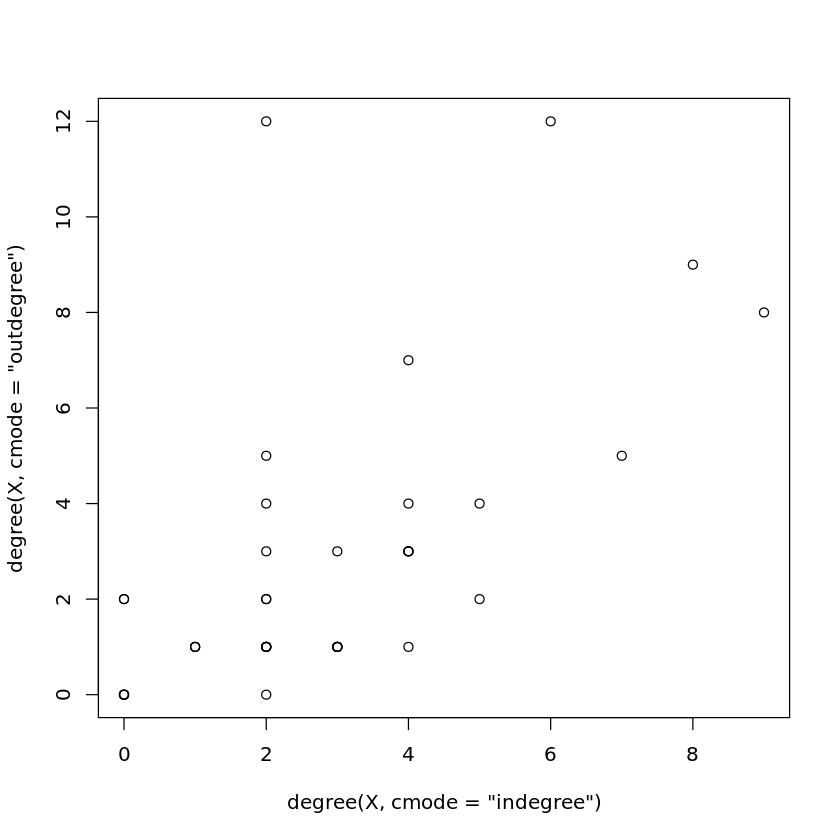

In [16]:
plot( degree(X, cmode='indegree'), degree(X, cmode='outdegree'))

One way to summarise the association between indegree and outdegree is to calculate the correlation. In order to avoid big code chunks, define a function that calculates the correlation between in- and out-degre:

In [17]:
deg.cor <- function(X)
{
  degcorr <- cor( degree(X,cmode='indegree'), degree(X,cmode='outdegree'))
  degcorr
}

You can use this function in the exact same way you use, for example, `centralization`:

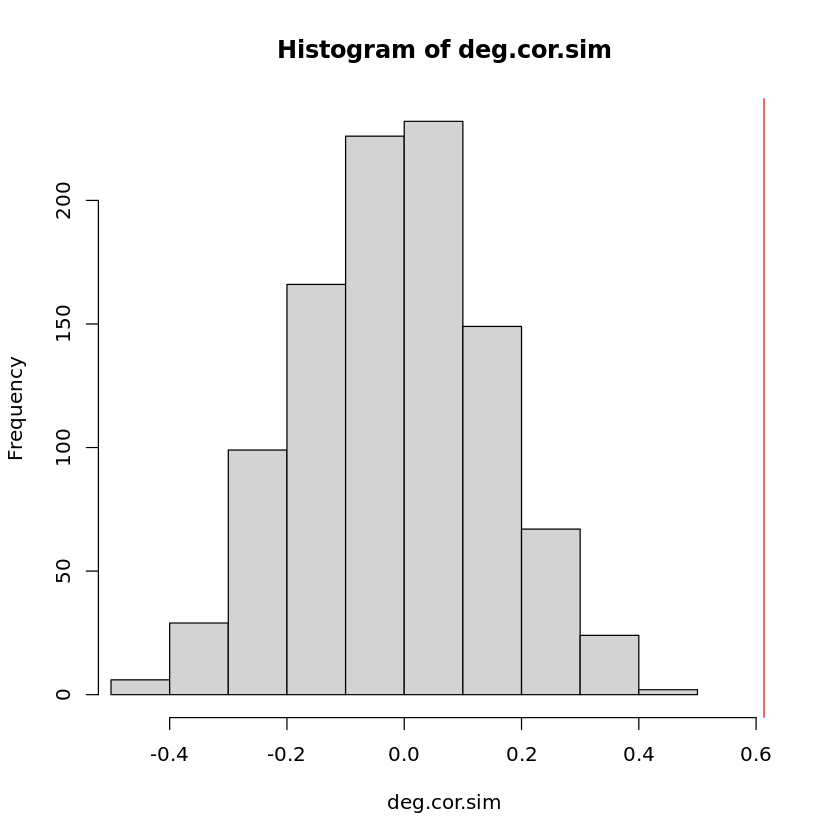

In [18]:
deg.cor.obs <-  deg.cor( X )

deg.cor.sim <- apply(Xsim,
                 1,
                 deg.cor ) 

hist(deg.cor.sim, xlim=range(deg.cor.obs,deg.cor.sim))
abline(v =deg.cor.obs, col='red')

> Functions in `sna` will work the same on $m \times n \times n$ arrays of networks and lists of networks of length $m$, and return the same output. User-defiend functions may be different.  

For *lists* of network variables, you need to use `lapply` and then convert the output from a list to a vector:

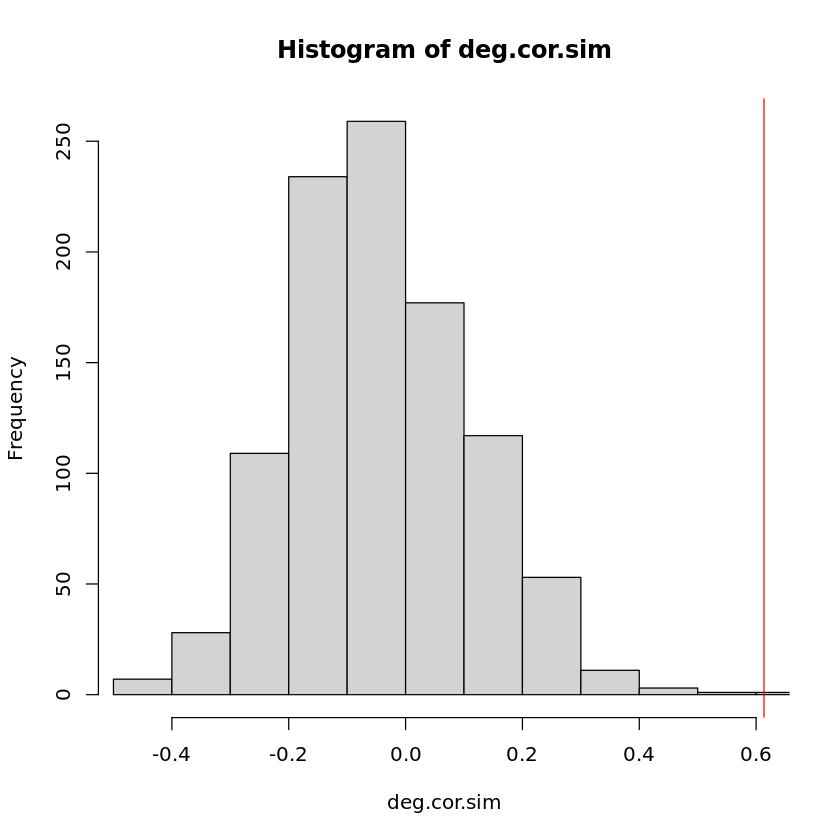

In [19]:
deg.cor.obs <-  deg.cor(X)
# Xudegs is a list of networks, so we need to use
# 'lapply' rather than 'apply'
deg.cor.sim <- lapply(Xoutdegs ,
                 deg.cor )# the function you want to apply to each element  Xoutdegs[[k]]
deg.cor.sim <- unlist(deg.cor.sim)# 'lapply' returns a list and here we want a verctor
hist(deg.cor.sim, xlim=range(deg.cor.obs,deg.cor.sim))
abline(v =deg.cor.obs, col='red')

For centralization, note that you can distinguish between indegree and outdegree centrality

In [19]:
centralization(X,degree,cmode="indegree")
centralization(X,degree,cmode="outdegree")

[1] 0.16759

[1] 0.248615

# Tasks

This is the main part of the assessment.

The exercise is based on the s50 dataset. Go to the page (https://www.stats.ox.ac.uk/~snijders/siena/s50_data.htm) and read the data description.

### Question 2 (2 points)

What is the maximum number of names respondents are allowed to nominate and what is the distribution of male and female students?


=== BEGIN MARK SCHEME ===

> (1 point) They could name up to 13 names as best friends.

> (1 point) The original data of $n=129$ pupils had both males and females but this is a subset of 50 females so there are no male students.

=== END MARK SCHEME ===


## Load the s50 data

Load the s50 data and plot it

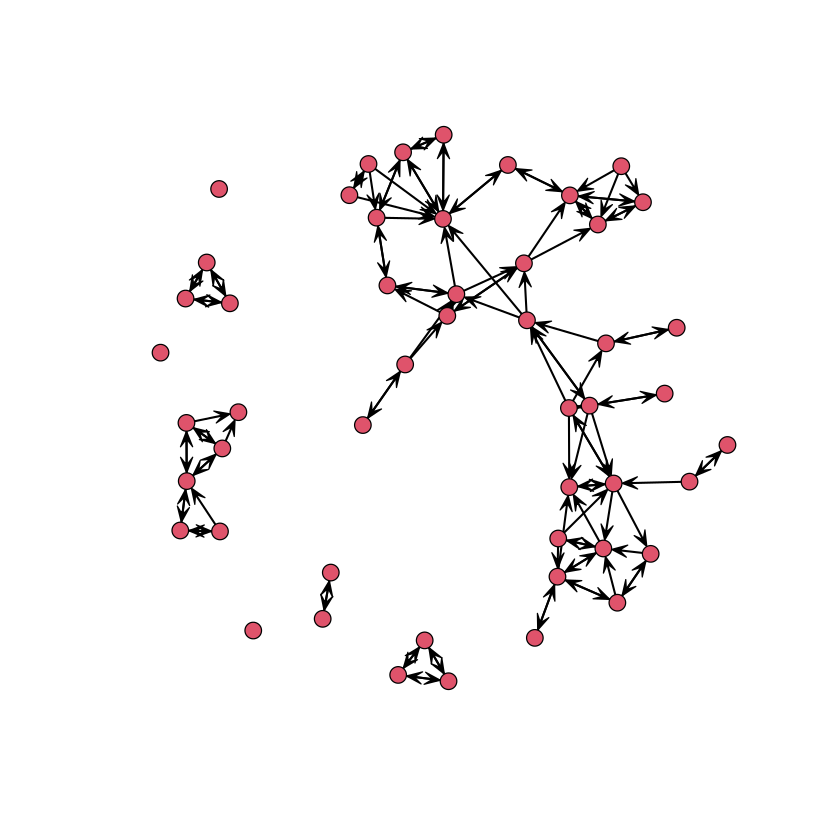

In [72]:
temp <- tempfile()
download.file("https://www.stats.ox.ac.uk/~snijders/siena/s50_data.zip",temp)
X <- as.matrix( read.table(unz(temp, "s50-network1.dat")) )
unlink(temp)
gplot(X)

Define `n` and `obs.dyad.census`

In [73]:
# you do not have to use these exact variable names, but
# if you chose different ones, make sure to be consistent in the sequel

### BEGIN SOLUTION
n <- dim(X)[1] # of course, you can type in n <- 50 or use n <- nrow(X)
obs.dyad.census <- dyad.census( X ) # this variable name is used in the solutions
### END SOLUTION
n
obs.dyad.census


[1] 50

Mut,Asym,Null
39,35,1151


# Generate your random networks
Using the **code provided above**, to generate networks from
* $X \thicksim Bern(p)$
* $X \thicksim U | d_{out}$
* $X \thicksim U | d_{in}$
* $X \thicksim U | d_{out},d_{in}$
* $X \thicksim U | MAN $

For each model make sure that you set the right parameters to match the s50 dataset.

## Bernoulli

Simulate your networks (again, you do not have to use the same variable names)


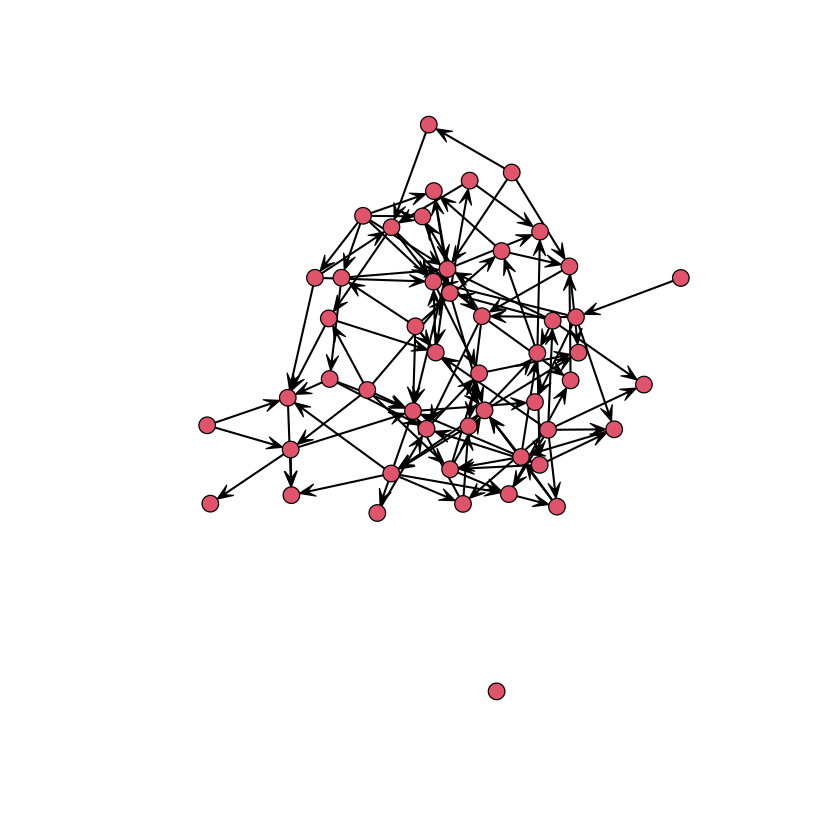

In [74]:
m <- 1000
### BEGIN SOLUTION
Xbern <- rgraph( n, # match network size
                m= m, # generate 500 random networks
                tprob = gden(X), # match tie-probability to density
                mode='digraph') # this is the main difference from tutorial 2
### END SOLUTION

gplot( Xbern[1,,] )# plot the first one of the networks - note that this requires
# that you called your array of networks XBern

## Uniform conditional on outdegree $X \thicksim U | d_{out}$

Draw networks that fixed outdegree, the starting network needs to be translated to a `network` object as the `ergm` function requires it):

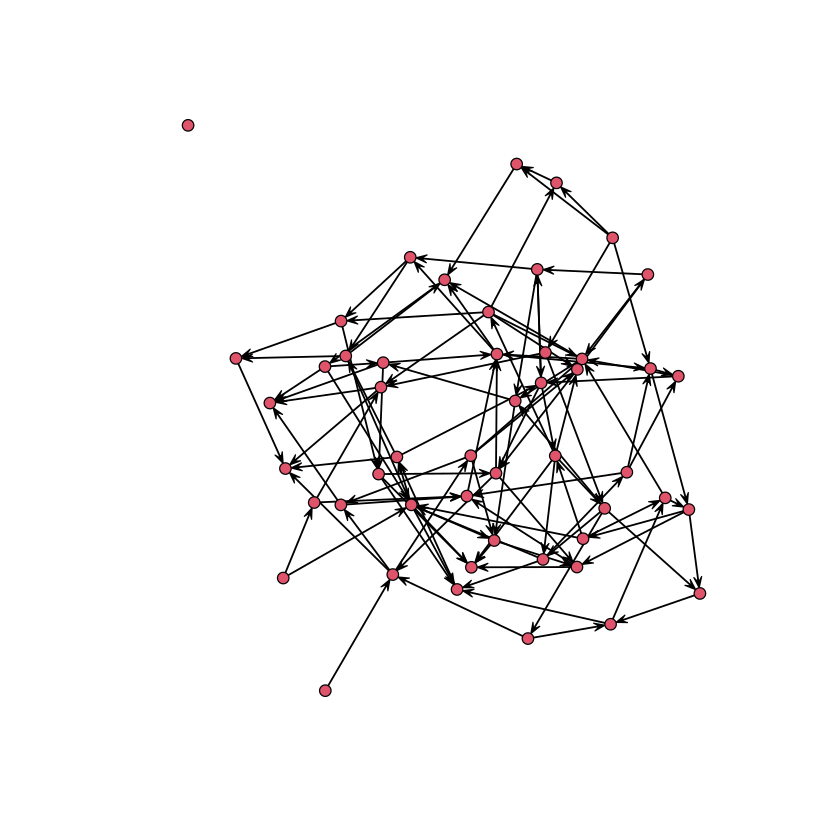

In [75]:
X.net <- as.network(X,directed=TRUE)
### BEGIN SOLUTION
Xoutdeg <- simulate(X.net~edges,
                   coef=c(0),# the role of coefficients will become clear further on
                   constraints=~odegrees,# this guarantees that only networks with the same *outdegree* are generated
                   nsim=m,# we set the number of draws a bit lower to save time
                   control=control.simulate(MCMC.burnin=100000))# 
### END SOLUTION
plot( Xoutdeg[[1]] ) #  plot the first network in the *list* of networks
# NOTE: the `network` package knows that 'plot' for a network object means 'gplot'


## Uniform conditional on indegree $X \thicksim U | d_{in}$

Draw networks that fixed outdegree

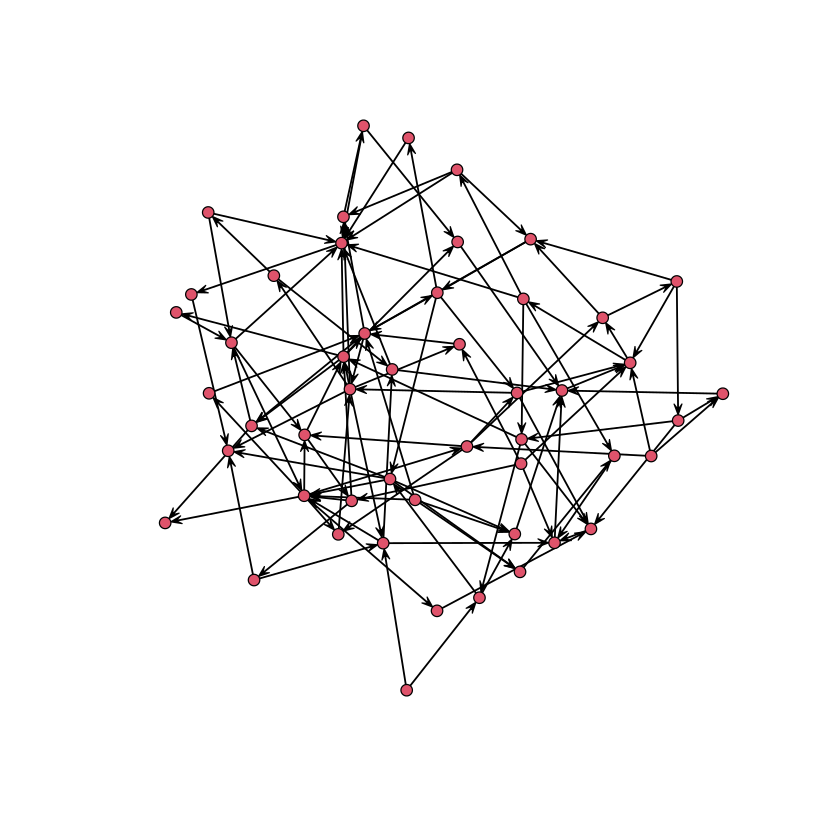

In [76]:
# Use the code from the Kapferer example an be careful to adopt the right bits
### BEGIN SOLUTION
Xindegs <- simulate(X.net~edges,
                   coef=c(0),# the role of coefficients will become clear further on
                   constraints=~idegrees,# this guarantees that only networks with the same *indegree* are generated
                   nsim=m,# we set the number of draws a bit lower to save time
                   control=control.simulate(MCMC.burnin=100000))# you 
### END SOLUTION
plot( Xindegs[[1]] ) #  plot the first network in the *list* of networks

## Uniform conditional on outdegree and indegree $X \thicksim U | d_{out},d_{in}$

Draw networks that fixed both outdegree and outdegree

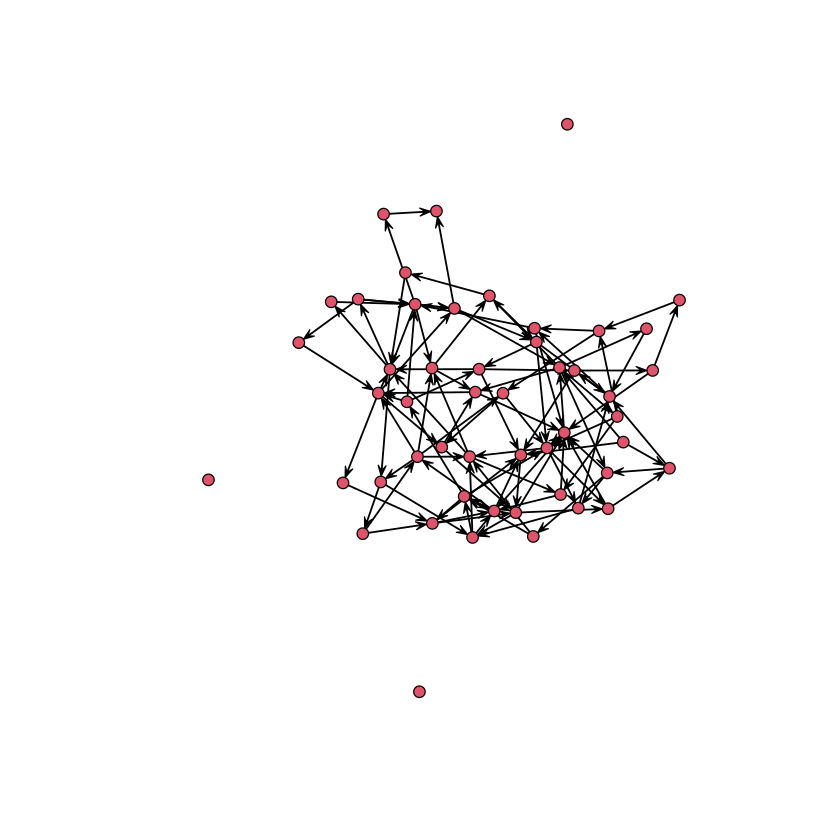

In [77]:
# Use the code from the Kapferer example an be careful to adopt the right bits
### BEGIN SOLUTION
Xdegs <- simulate(X.net~edges,
                   coef=c(0),# the role of coefficients will become clear further on
                   constraints=~degrees,# this guarantees that only networks with the same in/ and outdegree are generated
                   nsim=m,# we set the number of draws a bit lower to save time
                   control=control.simulate(MCMC.burnin=100000))# 
### END SOLUTION

plot( Xdegs[[1]] ) # plot the first network in the *list* of networks

## Uniform conditional on dyad census $X \thicksim U | MAN $

Draw networks that have the right prescribed dyad census


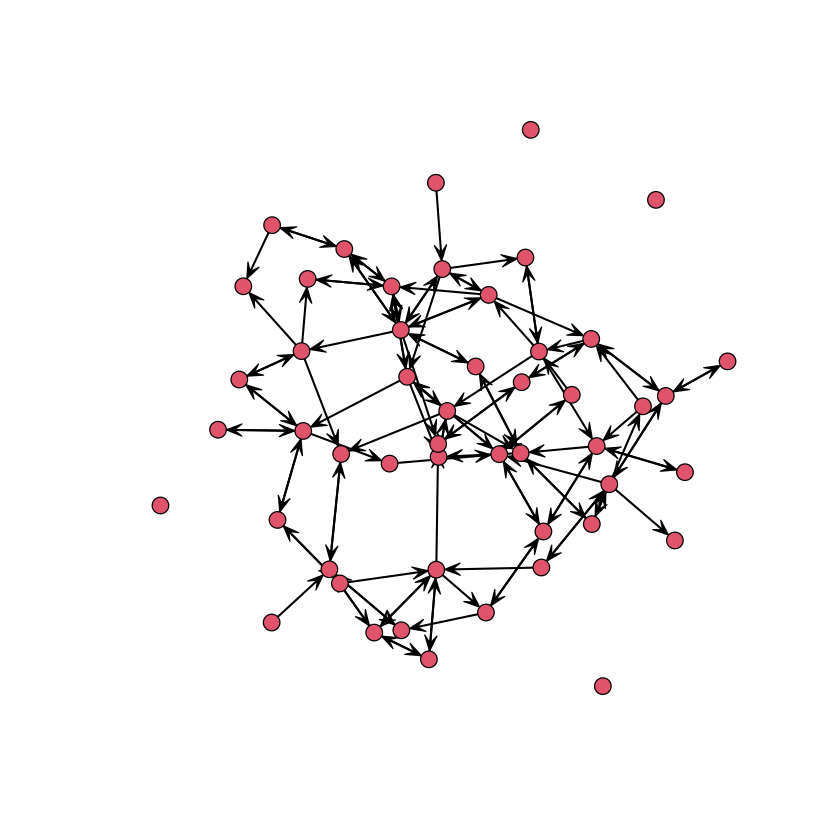

In [78]:
# Use the code from the Kapferer example an be careful to adopt the right bits
### BEGIN SOLUTION
Xuman <- rguman( n =m,# generate 1000 random networks # match network size
                 nv = n, # the size of the networks
                 mut = obs.dyad.census[1],# the number of mutual dyads
                 asym = obs.dyad.census[2],# the number of asymetric dyads
                 null = obs.dyad.census[3],# the number of null dyads
                 method='exact') # make sure these are undirected graphs
### END SOLUTION
# If you get an ERROR, make sure that you have the right dyad census and right 'n'
gplot( Xuman[1,,] ) # plot the first network in the m times n times n *array of networks*

# Dyad census

After you had read in the dataset you calculated the dyad census. Now test if there is more mutual dyads than you would expect, holding different properties constant. You may based this test on histograms alone or formally testing the numbers as in the Week 10 tutorial. Think carefully about which null-distributions to use

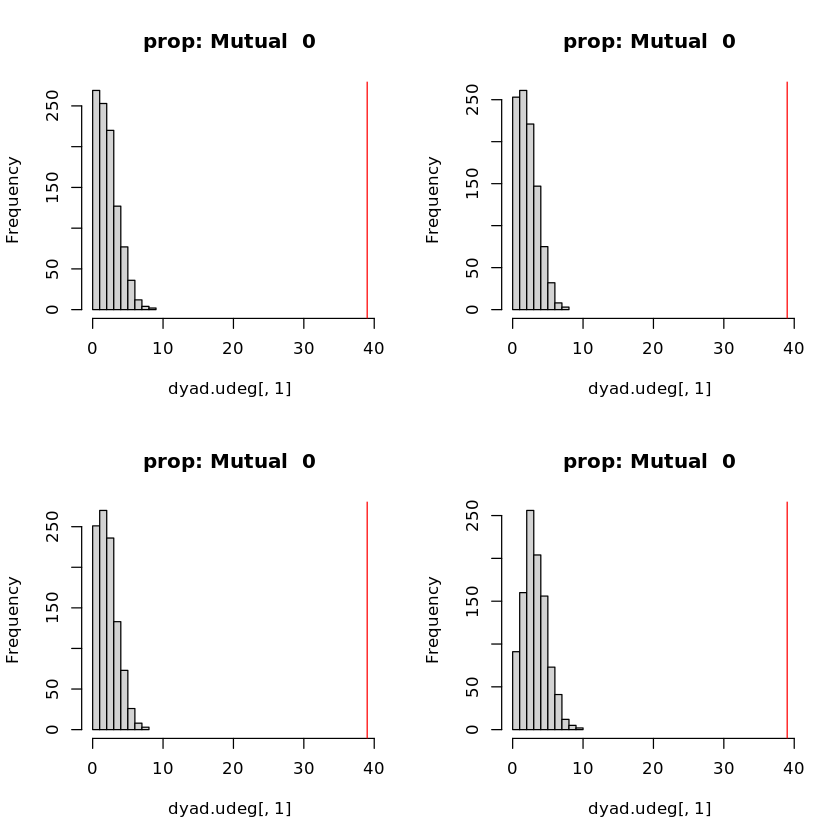

In [79]:
# Write your R-code in this code chunk - there are no hidden tests here so 
# you can use this space for what you need in order to answer Question 3
### BEGIN SOLUTION
par(mfrow=c(2,2))
dyad.udeg <- dyad.census(Xbern)
hist( dyad.udeg[,1] ,
      xlim = range(dyad.udeg[,1],obs.dyad.census[1]),
      main = paste('prop: Mutual ', mean(dyad.udeg[,1]>obs.dyad.census[1])) )
abline( v = obs.dyad.census[1], col ='red')
dyad.udeg <- dyad.census(Xoutdeg)
hist( dyad.udeg[,1] ,
      xlim = range(dyad.udeg[,1],obs.dyad.census[1]),
      main =  paste('prop: Mutual ', mean(dyad.udeg[,1]>obs.dyad.census[1])) )
abline( v = obs.dyad.census[1], col ='red')
dyad.udeg <- dyad.census(Xindegs)
hist( dyad.udeg[,1] ,
      xlim = range(dyad.udeg[,1],obs.dyad.census[1]),
      main =  paste('prop: Mutual ', mean(dyad.udeg[,1]>obs.dyad.census[1])) )
abline( v = obs.dyad.census[1], col ='red')
dyad.udeg <- dyad.census(Xdegs)
hist( dyad.udeg[,1] ,
      xlim = range(dyad.udeg[,1],obs.dyad.census[1]),
      main =  paste('prop: Mutual ', mean(dyad.udeg[,1]>obs.dyad.census[1])) )
abline( v = obs.dyad.census[1], col ='red')
### END SOLUTION

### Question 3 (4 points)

For your distributions, what was the larges proportion of simulated graphs that had as large a number of mutual dyads or greater? Provide your numerical answer in the code block below

In [80]:
prop <- c()
### BEGIN SOLUTION

prop <- 0 # if you found somethign different from 0, either
# (i) a miracle happened, or
# (ii) you have drawn the wrong networks or use the wrong dyad census
# NB: if student has tested the dyad census based on U |MAN they have not understood the exercise
# they can be awarded 1 point of every other test is correct

### END SOLUTION

In [81]:
# this cell contains a hidden test that your answer to Question 3 should pass
### BEGIN HIDDEN TESTS
expect_equal(prop, 0 ) 
### END HIDDEN TESTS

### Question 4 (4 points)

What can be conclude based upon $U \mid d_{out},d_{in}$, can you provide a brief (one sentence) plain language interpretation


=== BEGIN MARK SCHEME ===

> People that send and receive many ties give themselvs more opportunity to have reciprochated ties but this is not enough to explain the high degree of mutuality

> Any other thoughtful answer that wither relate reciprocity to the fixed in and outdegrees is fine

> if the interpreation is a literal one, 'that some people are more active and/or more popular does not explain...' is fine as well

=== END MARK SCHEME ===


Describe the task here!

# Centralization

Plot the indegree distribution

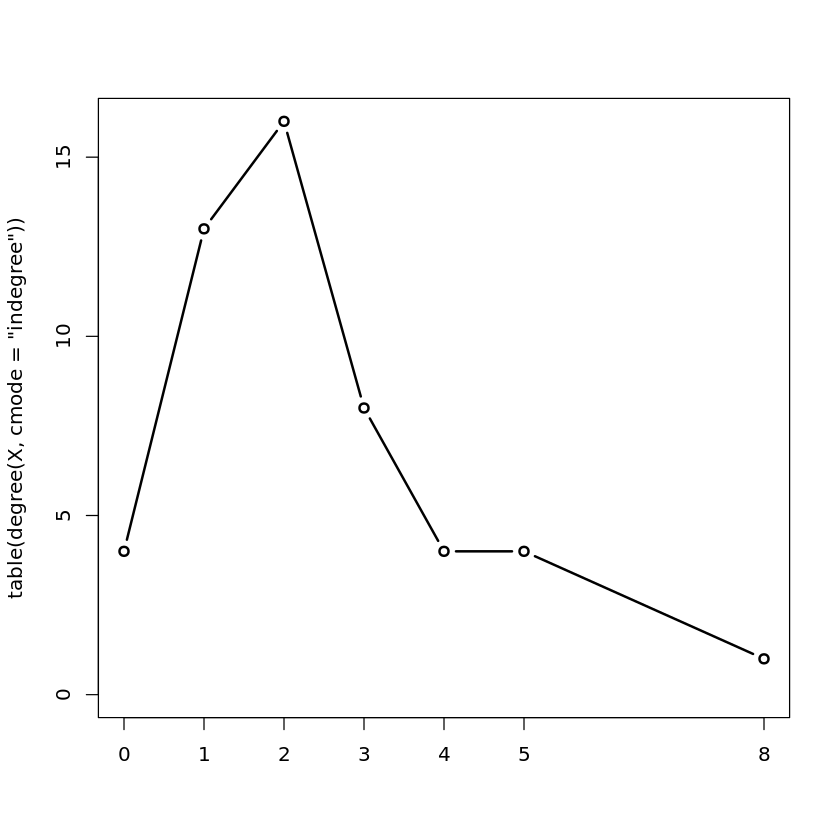

In [82]:
plot( table( degree( X , cmode='indegree') ) , type='b')

Does it seem as if popularity is evenly distributed in the network or not? Let us calculate the centralization in indegrees

In [83]:
Cent.obs <- centralization(X,# the observed network
                           degree, # the centrality index we want
                           cmode="indegree",# and the type we want the index to be based on
                           normalize=FALSE, mode='digraph')
Cent.obs 

[1] 287

Now, test centralization using your simulations from the null distributions. You may based this test on histograms alone or formally testing the numbers as in the Week 10 tutorial. Think carefully about which null-distributions to use

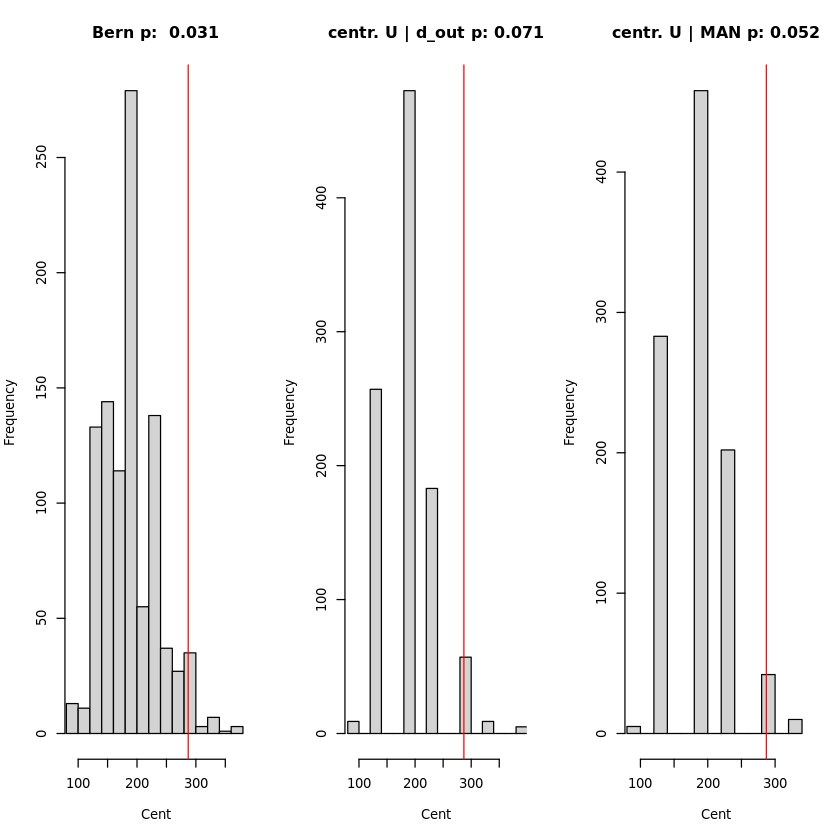

In [84]:
# Write your R-code in this code chunk - there are no hidden tests here so 
# you can use this space for what you need in order to answer Question 5
### BEGIN SOLUTION
par(mfrow=c(1,3))

Cent<- centralization(Xbern,# the array of simulated networks
                      degree,cmode="indegree",normalize=FALSE, mode='digraph')

hist( Cent , xlim=range(Cent,Cent.obs) , main= paste( 'Bern p: ',mean(Cent>=Cent.obs)) )
abline(v=Cent.obs , col='red')
 
Cent<- centralization(Xoutdeg,# the array of simulated networks
                      degree,cmode="indegree",normalize=FALSE, mode='digraph')

hist( Cent , xlim=range(Cent,Cent.obs) , main=paste('centr. U | d_out p:' ,mean(Cent>=Cent.obs) ) )
abline(v=Cent.obs , col='red')

Cent<- centralization(Xuman,# the array of simulated networks
                      degree,cmode="indegree",normalize=FALSE, mode='digraph')

hist( Cent , xlim=range(Cent,Cent.obs) , main=paste( 'centr. U | MAN p:',mean(Cent>=Cent.obs)) )
abline(v=Cent.obs , col='red')

### END SOLUTION

### Question 5 (4 points)

Are any of the models able to explain centralization, if so provide a brief (one sentence) plain language interpretation


=== BEGIN MARK SCHEME ===

There is quite some variation even with $m=1000$ networks here so different models might be the winner here but 
$U | d_{out}$ should come the closest

> Bernoulli: the heterogeneity in popularity can be explained by chance

> U| d_out: given that there are some people that send many more ties than others, through either reciprocation or correlation between in- and out-degree, these people might also receive more nominations. It could of course be that the correlation between in and out-degree is negative, in which case knowing who is active means that you know who is not popular.

> U |MAN: if you take reciprocity into account you can explain why some people are more popular. Assymetric dyads will inform the model of instances of nodes receiving ties (bu not sending) and the mutual dyads again distribute ties so that people that send ties aso receive ties.

> Any other thoughtful answer that wither relate reciprocity to the fixed in and outdegrees is fine

> if the interpreation is a literal one, 'that some people are more active and/or more popular does not explain...' is fine as well

=== END MARK SCHEME ===


## Assortativity

Plot the indegrees against the outdegrees

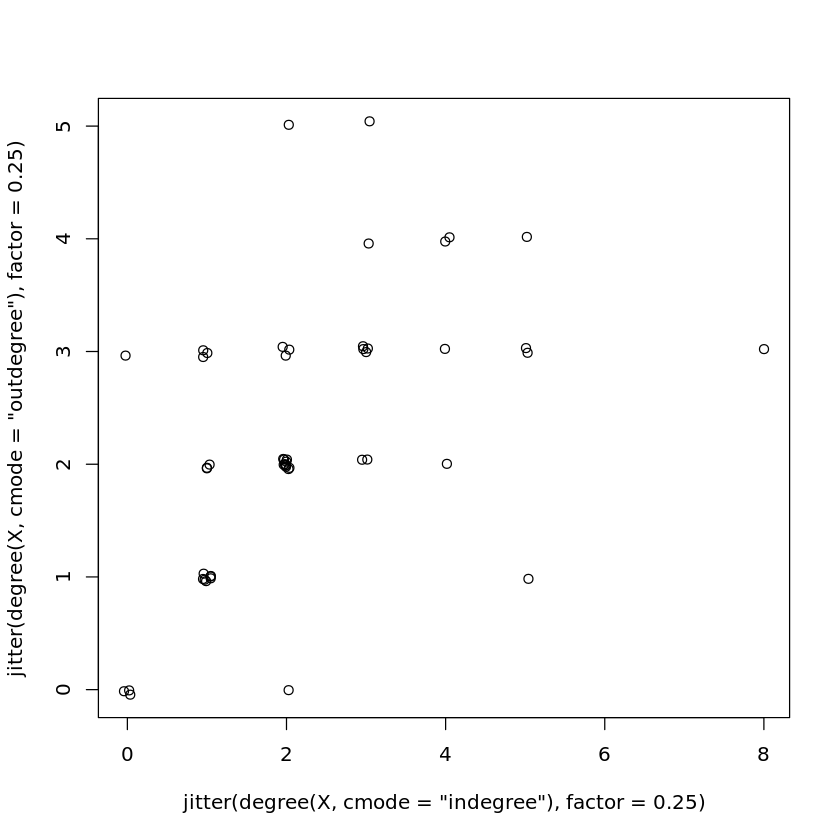

In [85]:
plot( jitter( degree(X, cmode='indegree'), factor =.25 ),# jitter adds some random noise so 
     jitter(degree(X, cmode='outdegree'), factor=.25))# that the points are on on top of eachother

Does it look that people who send a lot of ties also receive a lot of ties? 

Calculate the correlation between indegree and outdegree in the network

In [86]:
deg.cor.obs <-  deg.cor(X)
deg.cor.obs

[1] 0.4849088

Using the code above, test whether this correlation is higher than expected using appropriate null distributions. Like in the previous questions, you may use 

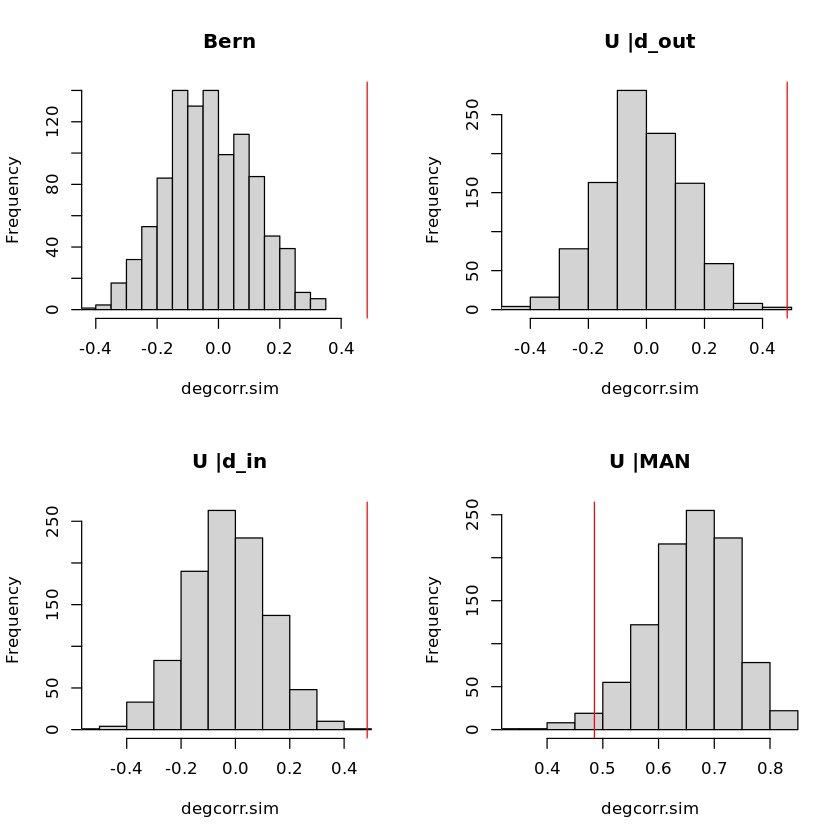

In [87]:
# Write your R-code in this code chunk - there are no hidden tests here so 
# you can use this space for what you need in order to answer Question 5
### BEGIN SOLUTION
par( mfrow=c(2,2))
degcorr.sim <- apply( Xbern , 1,  deg.cor )

hist(degcorr.sim , xlim=range(degcorr.sim  , deg.cor.obs ) , main='Bern')
abline( v =  deg.cor.obs, col='red')

degcorr.sim <- unlist( lapply( Xoutdeg ,  deg.cor ) )

hist(degcorr.sim , xlim=range(degcorr.sim  , deg.cor.obs )  , main='U |d_out')
abline( v =  deg.cor.obs, col='red')

degcorr.sim <- unlist( lapply( Xindegs ,   deg.cor )  )

hist(degcorr.sim , xlim=range(degcorr.sim  , deg.cor.obs ), main='U |d_in' )
abline( v =  deg.cor.obs, col='red')

degcorr.sim <- apply( Xuman , 1,  deg.cor )

hist(degcorr.sim , xlim=range(degcorr.sim  ,deg.cor.obs) , main='U |MAN' )
abline( v =  deg.cor.obs, col='red')
### END SOLUTION

### Question 6 (4 points)

Is there a process that seems to account for the correlation between popularity and activity? Try to provide an interpretation if this is the case


=== BEGIN MARK SCHEME ===



> Yes, it appears as if $U | MAN$ generate a high correlation between in and outdegree (and expected value around 0.66). Since this model controls for reciprocity, each mutual tie a node has adds one to both the outdegree and the indegree of that node.

Note: if you have used $U |d_{out},d_{in}$ as well you have already fixed the correlation so you cannot use that distribution to test

=== END MARK SCHEME ===


## Triad census

Recall, that for directed networks there are 16 different triads.

![The 16 MAN triads for directed networks .](https://raw.githubusercontent.com/johankoskinen/BayesERGM/main/data/triadcensus.png)

Each triad is labeled by its dyad census - this is called the MAN labeling scheme.

Calculate the triad census for the observed network

In [63]:
triad.obs <- triad.census(X)
triad.obs 

003,012,102,021D,021U,021C,111D,111U,030T,030C,201,120D,120U,120C,210,300
16243,1470,1724,5,18,21,42,30,5,0,15,6,5,2,9,5


### Test triads

Here you are going to focus on the transitive triad 030T, the cyclic triad 030C, and the dense triad (of Simmilean tie) 300. In the order of triads, these are number 9, 10, and 16, respectively.

For each random graph model in turn, plot the distribution of these three triads and test whether the observed network has significantly more of these triads than expected under the random graph


### Bernoulli 

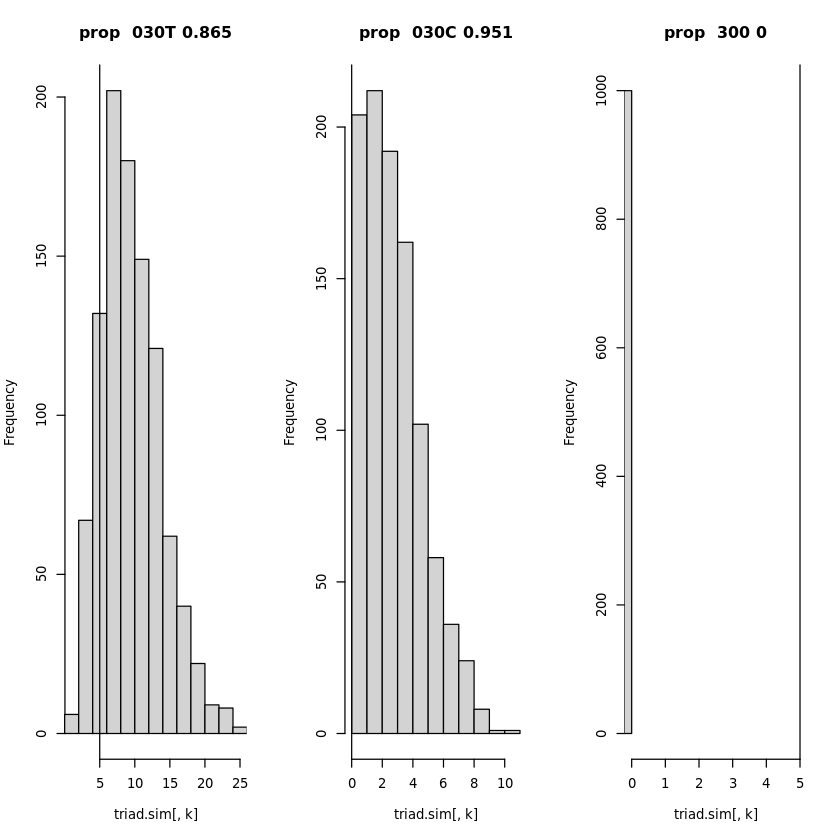

In [65]:
# You can use this as a template 

par(mfrow=c(1,3))
triad.sim <- triad.census(Xbern)
for (k in c(9,10,16)){
hist( triad.sim[,k] ,
      xlim = range(triad.sim[,k],triad.obs[k]),
      main = paste('prop ',colnames(triad.obs)[k], mean( triad.sim[,k]>triad.obs[k] ) )  )
abline( v = triad.obs[k]  )  
}


###  Conditional on oudegree $U | d_{out}$ (1 point)


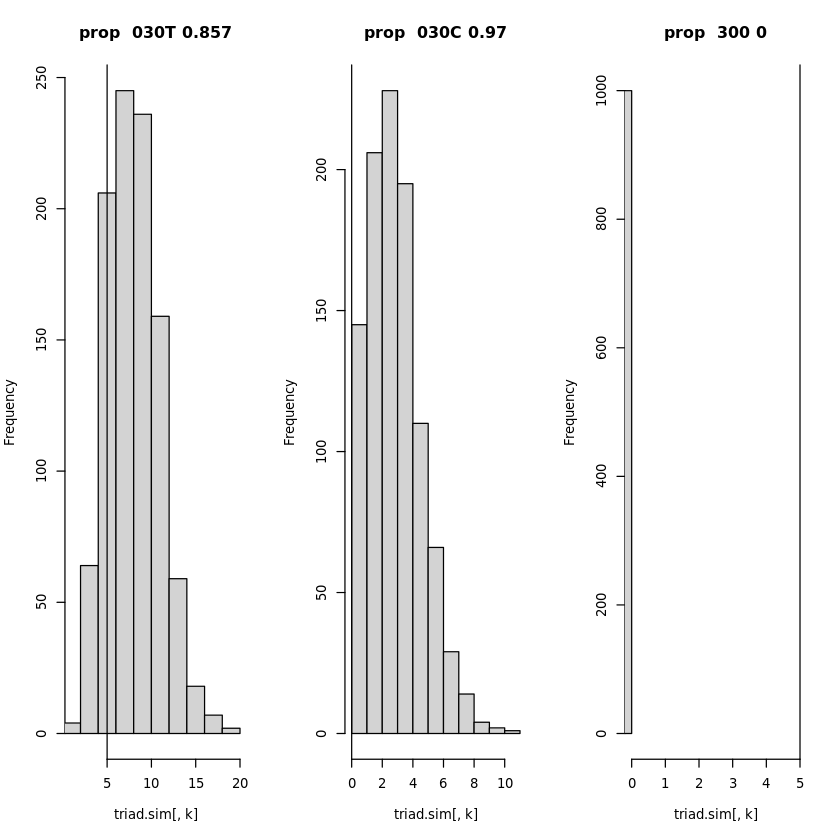

In [68]:
# Write your R-code in this code chunk - there are no hidden tests here so 
# you can use this space for what you need in order to test and plot
par(mfrow=c(1,3))
### BEGIN SOLUTION
triad.sim <- triad.census(Xoutdeg)
for (k in c(9,10,16)){
  hist( triad.sim[,k] ,
        xlim = range(triad.sim[,k],triad.obs[k]),
        main = paste('prop ',colnames(triad.obs)[k], mean( triad.sim[,k]>triad.obs[k] ) )  )
  abline( v = triad.obs[k]  )  
}
### END SOLUTION

###  Conditional on inegree $U | d_{in}$ (1 point)

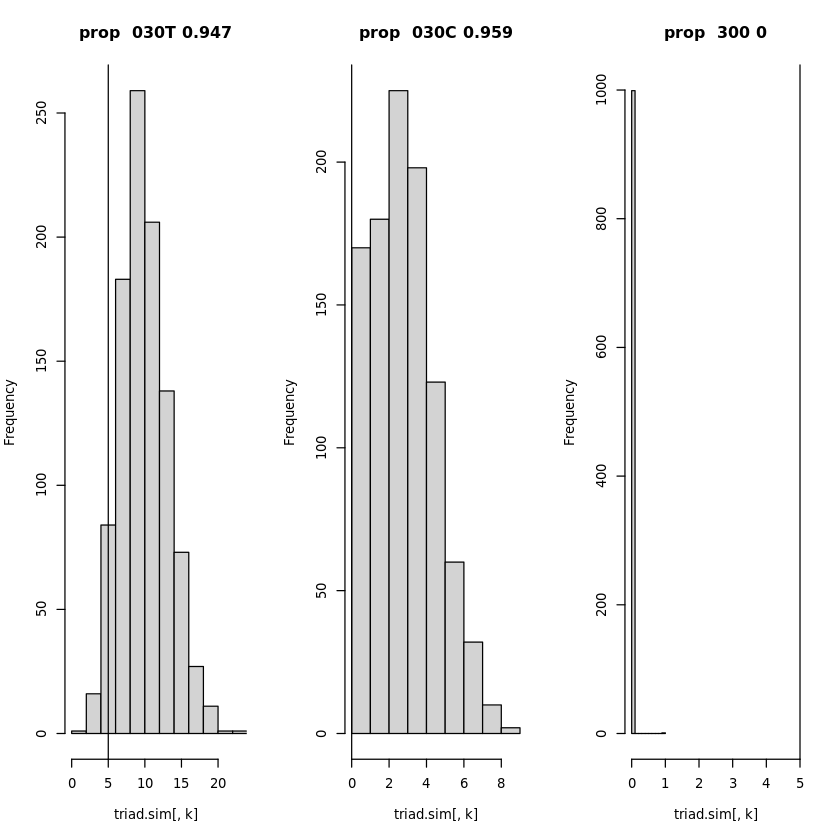

In [69]:
# Write your R-code in this code chunk - there are no hidden tests here so 
# you can use this space for what you need in order to test and plot
par(mfrow=c(1,3))
### BEGIN SOLUTION
triad.sim <- triad.census( Xindegs)
for (k in c(9,10,16)){
  hist( triad.sim[,k] ,
        xlim = range(triad.sim[,k],triad.obs[k]),
        main = paste('prop ',colnames(triad.obs)[k], mean( triad.sim[,k]>triad.obs[k] ) )  )
  abline( v = triad.obs[k]  )  
}
### END SOLUTION

###  Conditional on outdegree and inegree $U | d_{out},d_{in}$ (1 point)

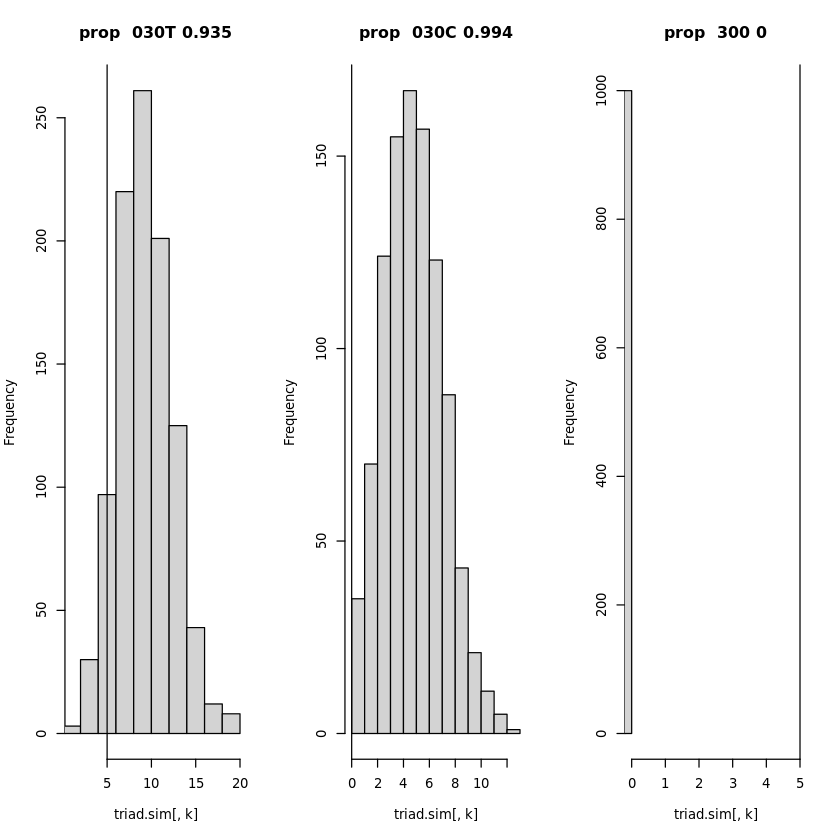

In [70]:
# Write your R-code in this code chunk - there are no hidden tests here so 
# you can use this space for what you need in order to test and plot
par(mfrow=c(1,3))
### BEGIN SOLUTION
triad.sim <- triad.census(Xdegs)
for (k in c(9,10,16)){
  hist( triad.sim[,k] ,
        xlim = range(triad.sim[,k],triad.obs[k]),
        main = paste('prop ',colnames(triad.obs)[k], mean( triad.sim[,k]>triad.obs[k] ) )  )
  abline( v = triad.obs[k]  )  
}
### END SOLUTION

###  Conditional on dyad census $U |MAN$ (1 point)

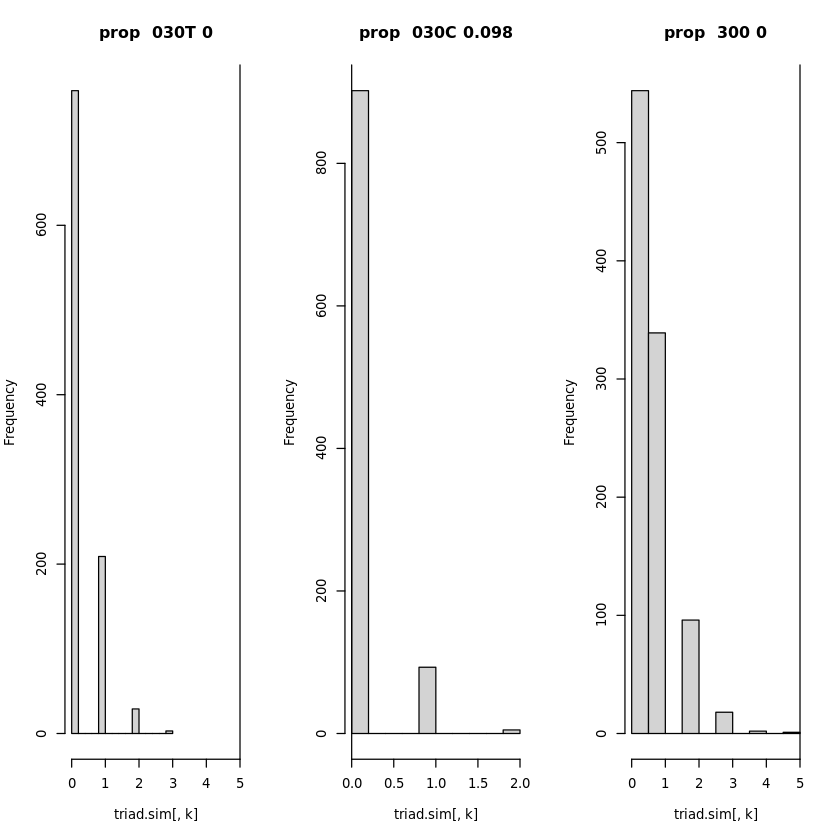

In [71]:
# Write your R-code in this code chunk - there are no hidden tests here so 
# you can use this space for what you need in order to test and plot
par(mfrow=c(1,3))
### BEGIN SOLUTION
triad.sim <- triad.census(Xuman)
for (k in c(9,10,16)){
  hist( triad.sim[,k] ,
        xlim = range(triad.sim[,k],triad.obs[k]),
        main = paste('prop ',colnames(triad.obs)[k], mean( triad.sim[,k]>triad.obs[k] ) )  )
  abline( v = triad.obs[k]  )  
}
### END SOLUTION

### Question 7 (4 points)

looking at 030T compare the results for Bernoulli, $U | d_{out}, d_{in}$, and $U | MAN$, and explain this in terms of status hierarchy


=== BEGIN MARK SCHEME ===

3 points for correctly stating the results. An additional point for reflecting on them together.

> There is more hierarchial transitive triangles than compared to when ties are formed by chance. 

> When you control for atractiveness and activity, however, there is less transitive triads. 

> When you take reciprochation into account, we see that there is a lot more transitive closure than the model would predict

> So, in other words, if you do not take into account the tendency for reciprocation, you do not detect the transitivity which is associated with local hierachy. Maybe high status people chose other high status people. Reflecting back on assortativity, UMAN was the model that produced the highest assortativity.

=== END MARK SCHEME ===


### Question 8 (3 points)

looking at 300, interpret the result with reference to $U | MAN$.


=== BEGIN MARK SCHEME ===



> None of the models manage to come even close to producing the observed number of dense triangles. There is clear clustering of mutual dyads that cannot be explained by chance. This also creates clustered regions that are not visible in the random networks. The UMAN at least produces a few dense triangles but it is clear that reciprocity alone cannot account for the creation of the dense triangles.

=== END MARK SCHEME ===
